In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [2]:
df = pd.read_pickle("data/final_dataset.pkl")

In [3]:
df.head()

,name,funding_rounds,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,investor_funding_total,month_between_funding,new_status
0,#waywire,1.0,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750000.0,0.000000,acquired
1,1000memories,2.0,15000.0,2520000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5055000.0,13.700000,acquired
2,100Plus,2.0,750000.0,500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1250000.0,0.933333,acquired
3,10BestThings,1.0,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,0.000000,closed
4,170 Systems,1.0,0.0,14000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28000000.0,0.000000,acquired


# 1. Preprocess all the features

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3877 entries, 0 to 3876
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    3877 non-null   object 
 1   funding_rounds          3877 non-null   float64
 2   seed                    3877 non-null   float64
 3   venture                 3877 non-null   float64
 4   equity_crowdfunding     3877 non-null   float64
 5   undisclosed             3877 non-null   float64
 6   convertible_note        3877 non-null   float64
 7   debt_financing          3877 non-null   float64
 8   angel                   3877 non-null   float64
 9   grant                   3877 non-null   float64
 10  private_equity          3877 non-null   float64
 11  post_ipo_equity         3877 non-null   float64
 12  post_ipo_debt           3877 non-null   float64
 13  secondary_market        3877 non-null   float64
 14  product_crowdfunding    3877 non-null   

# 2. Create response variable (success) (has to be 0|1)
- closed = 0, IPO|acquired = 1
- balance your dataset: same number of success = 1 as success = 0

In [5]:
df = (df
      .assign(success=np.where(df["new_status"] == "closed", 0, 1))
      .drop(columns=["new_status"]))

In [6]:
df.head()

,name,funding_rounds,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,investor_funding_total,month_between_funding,success
0,#waywire,1.0,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750000.0,0.000000,1
1,1000memories,2.0,15000.0,2520000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5055000.0,13.700000,1
2,100Plus,2.0,750000.0,500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1250000.0,0.933333,1
3,10BestThings,1.0,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,0.000000,0
4,170 Systems,1.0,0.0,14000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28000000.0,0.000000,1


# Undersampling
**balance your dataset: same number of success = 1 as success = 0**

In [7]:
df["success"].value_counts()

1    2647
0    1230
Name: success, dtype: int64

In [8]:
df_success = df[df["success"] == 1].copy()
df_fail = df[df["success"] == 0].copy()

In [9]:
df_undersampled = df_success.sample(len(df_fail)).reset_index(drop=True)

In [10]:
df = pd.concat([df_undersampled, df_fail], ignore_index=True).sample(frac=1).reset_index(drop=True)

# Success/Failure 

In [11]:
df.isnull().values.any()

False

# 3. Split Train Test
- split dataset to train and test


In [13]:
df.dtypes

name                       object
funding_rounds            float64
seed                      float64
venture                   float64
equity_crowdfunding       float64
undisclosed               float64
convertible_note          float64
debt_financing            float64
angel                     float64
grant                     float64
private_equity            float64
post_ipo_equity           float64
post_ipo_debt             float64
secondary_market          float64
product_crowdfunding      float64
investor_funding_total    float64
month_between_funding     float64
success                     int64
dtype: object

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train, test = train_test_split(df, test_size=.2, random_state=17)

In [16]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [17]:
train.head()

,name,funding_rounds,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,investor_funding_total,month_between_funding,success
0,BetaUsersNow.com,1.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,0.000000,0
1,Troika Networks,1.0,0.0,14400000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28800000.0,0.000000,1
2,SeatSwapr,1.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,0.000000,0
3,My True Fit,1.0,0.0,4360000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4360000.0,0.000000,0
4,Moonshoot,2.0,0.0,6760000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6760000.0,25.766667,0


In [18]:
test.head()

,name,funding_rounds,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,investor_funding_total,month_between_funding,success
0,SkyData Systems,1.0,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000000.0,0.000000,0
1,Virtual Telephone & Telegraph,2.0,0.0,0.0,0.0,0.0,0.0,500000.0,3500000.0,0.0,0.0,0.0,0.0,0.0,0.0,4000000.0,17.533333,0
2,Myrio,1.0,0.0,20500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20500000.0,0.000000,0
3,Infineta Systems,2.0,0.0,30000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60000000.0,13.166667,0
4,College Tonight,2.0,0.0,1644500.0,0.0,0.0,0.0,0.0,600000.0,0.0,0.0,0.0,0.0,0.0,0.0,3889000.0,12.200000,0


In [19]:
train["success"].value_counts(normalize=True)

1    0.504065
0    0.495935
Name: success, dtype: float64

In [20]:
test["success"].value_counts(normalize=True)

0    0.51626
1    0.48374
Name: success, dtype: float64

In [21]:
train.to_pickle("data/train.pkl")
test.to_pickle("data/test.pkl")

In [22]:
# categorize columns
num_cols = ["funding_rounds","seed","venture","equity_crowdfunding","undisclosed","convertible_note","debt_financing","angel","grant","private_equity","post_ipo_equity","post_ipo_debt","secondary_market","product_crowdfunding","investor_funding_total","month_between_funding"]
name = ["name"]
response = ["success"]

train_X = train[num_cols]
train_y = train[response].values.ravel()
test_X = test[num_cols]
test_y = test[response]

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# train model
lr = LogisticRegression(max_iter=1000)
lr.fit(train_X, train_y)

LogisticRegression(max_iter=1000)

In [24]:
pred = lr.predict(test_X)

In [25]:
test_X.head()

,funding_rounds,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,investor_funding_total,month_between_funding
0,1.0,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000000.0,0.000000
1,2.0,0.0,0.0,0.0,0.0,0.0,500000.0,3500000.0,0.0,0.0,0.0,0.0,0.0,0.0,4000000.0,17.533333
2,1.0,0.0,20500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20500000.0,0.000000
3,2.0,0.0,30000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60000000.0,13.166667
4,2.0,0.0,1644500.0,0.0,0.0,0.0,0.0,600000.0,0.0,0.0,0.0,0.0,0.0,0.0,3889000.0,12.200000


In [26]:
test_y.head()

,success
0,0
1,0
2,0
3,0
4,0


In [27]:
pred

array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,

In [28]:
accuracy_score(test_y, pred)

0.6443089430894309

# Random Forest

In [29]:
def validate_model(train_X, train_y, test_X, test_y, model):
    ml = model()
    ml.fit(train_X, train_y)
    pred = ml.predict(test_X)
    print(f"""This model achieved an accuracy score of: {round(accuracy_score(test_y, pred), 4)}""")

In [30]:
from sklearn.ensemble import RandomForestClassifier

validate_model(train_X, train_y, test_X, test_y, RandomForestClassifier)

This model achieved an accuracy score of: 0.6707


# 4. Pick the best performing model (incl. hyperparameters)

- using train set:
    - run feature selection (i.e. RFE)
    - choose ML model (i.e. LogisticRegression or RandomForest)
    - Test on test set to establish a baseline
    - Re-iterate using hyperparameter tuning to tune your model

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
param_grid_rf = {"n_estimators": [100, 300, 1000],
                 "max_depth": [3, 10, None],
                 "min_samples_leaf": [1,4,10],
                 "max_features": ["auto", "sqrt"],
                 "min_samples_split": [2, 5, 10]}

tune_rf = GridSearchCV(RandomForestClassifier(),
                       param_grid=param_grid_rf,
                       cv=5,
                       scoring="accuracy")

In [33]:
tune_rf.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 10, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 4, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 1000]},
             scoring='accuracy')

- get params of best hyperparamteres
- validate model with best parameters

In [34]:
tune_rf.best_params_

{'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [35]:
rf = RandomForestClassifier(**tune_rf.best_params_)
rf.fit(train_X, train_y)
pred_rf = rf.predict(test_X)
print(f"""This model achieved an accuracy score of: {round(accuracy_score(test_y, pred_rf), 4)}""")

This model achieved an accuracy score of: 0.7073


# 5. Check variable importance and interpret

Feature: 0, Score: 0.06767
Feature: 1, Score: 0.06615
Feature: 2, Score: 0.24025
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00347
Feature: 5, Score: 0.00288
Feature: 6, Score: 0.01499
Feature: 7, Score: 0.01904
Feature: 8, Score: 0.00205
Feature: 9, Score: 0.00304
Feature: 10, Score: 0.07196
Feature: 11, Score: 0.01435
Feature: 12, Score: 0.00061
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.34339
Feature: 15, Score: 0.15013


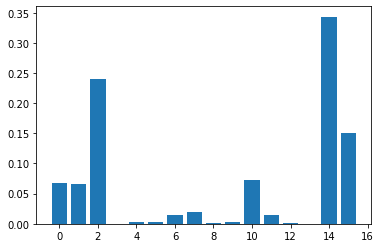

In [38]:
# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

--- 

# Presentation (Outline)

- Problem definition: Predicting success....
- Explain dataset (Kaggle, USA sample, how many startups, etc. )
- What is success? - closed, acquired, IPO EXPLAIN!!!
- How would you predict success? EDA!!!
    - Look at financing
        - What are typical financing options? How do they differ by success
    - You are predicting based on financing...
    
- Machine Learning, Success Predictor
- Explain your mode, your feature set and what it does
- Result
- **Answer: Which financing options are more useful in predciting the success of a company?**

- optional: Discussion